# Visualize registration loss landscapes

TODO: 
- update plot stylings: https://dawes.wordpress.com/2014/06/27/publication-ready-3d-figures-from-matplotlib/
- try widening the basins

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from tqdm import tqdm

from src import read_dicom, Detector, Siddon
from src.metrics import xcorr2

device = torch.device("cuda:0")

## Utility functions for the simulation

- Generate ground truth DRR
- Function for generating estimated DRRs
- Functions for scoring (NCC and F-norm)

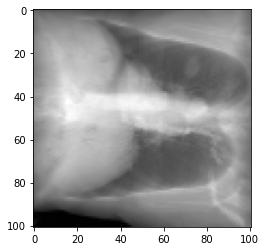

In [2]:
# DRR utility functions
volume, spacing = read_dicom("../data/cxr/")
isocenter = [0., 0., 0.]
siddon = Siddon(spacing, isocenter, volume, device)

def make_drr(source, center, height=101, delx=10.):
    """Detector parameters -> DRR"""
    detector = Detector(
        source=source,
        center=center,
        height=height,
        width=height,
        delx=delx,
        dely=delx,
        device=device
    )
    source = detector.source
    rays = detector.make_xrays()
    drr = siddon.raytrace(source, rays)
    return drr

def plot(drr):
    plt.imshow(drr.detach().cpu(), cmap="gray")
    plt.show()    

# Get the ground truth DRR
drr = make_drr([-100., 160., 160.], [500., 180., 161.])
plot(drr)

In [3]:
# Scoring functions
def get_normxcorr2(x, y, z):
    est = make_drr([x, y, z], [500., 180., 160.])
    return corr(drr, est)

def get_norm2(x, y, z):
    est = make_drr([x, y, z], [500., 180., 160.])
    return norm(drr, est)

def corr(drr, est, flip=False):
    x = xcorr2()
    if flip:
        est = est.T.flip(1)
    loss = x(drr.expand(1, 1, -1, -1), est.expand(1, 1, -1, -1)).item()
    if loss < 0:
        return corr(drr, est, flip=True)
    return loss

def norm(drr, est, flip=False):
    if flip:
        est = est.T.flip(1)
    loss = torch.norm(drr - est).item()
    if loss > 8e6:
        return norm(drr, est, flip=True)
    return loss

## Negative Normalized XCorr

In [4]:
xs = torch.arange(-130., -70., step=2)
ys = torch.arange(145., 176.)
zs = torch.arange(150., 171.)

# Get coordinate-wise correlations
xy_corrs = []
for x in tqdm(xs):
    for y in ys:
        xcorr = get_normxcorr2(x.item(), y.item(), 160.)
        xy_corrs.append(-xcorr)
XY = torch.tensor(xy_corrs).reshape(len(xs), len(ys))
        
xz_corrs = []
for x in tqdm(xs):
    for z in zs:
        xcorr = get_normxcorr2(x.item(), 160., z.item())
        xz_corrs.append(-xcorr)
XZ = torch.tensor(xz_corrs).reshape(len(xs), len(zs))
        
yz_corrs = []
for y in tqdm(ys):
    for z in zs:
        xcorr = get_normxcorr2(-100., y.item(), z.item())
        yz_corrs.append(-xcorr)
YZ = torch.tensor(yz_corrs).reshape(len(ys), len(zs))

100%|████████████████████████████████████████████████████████████████| 31/31 [00:12<00:00,  2.39it/s]


/home/vivekg/vivekg/miniconda3/envs/DiffDRR/lib/python3.7/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352464346/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


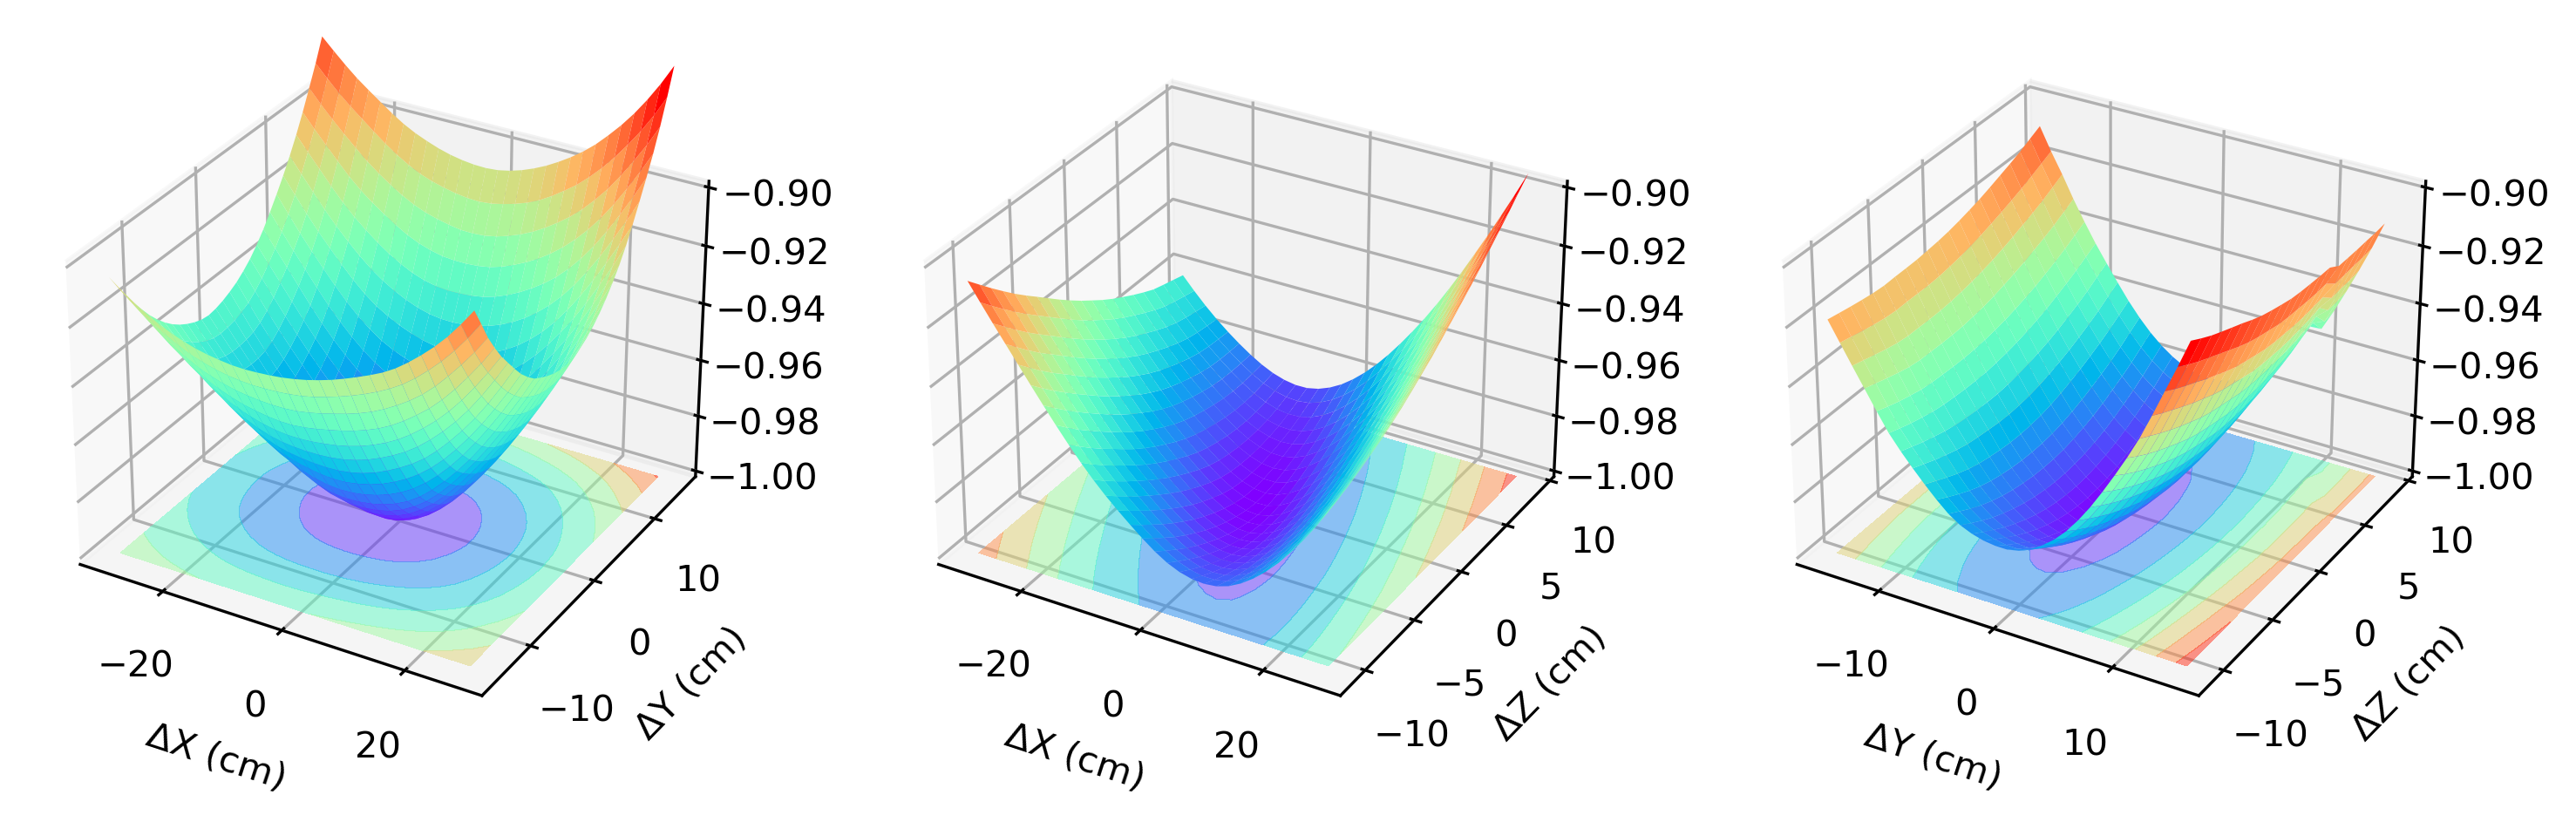

In [5]:
# Make the plots
xyx, xyy = torch.meshgrid(xs - (-100.), ys - 160.1)
xzx, xzz = torch.meshgrid(xs - (-100.), zs - 161.)
yzy, yzz = torch.meshgrid(ys - 160.1, zs - 161.)

fig = plt.figure(figsize=plt.figaspect(1/3), dpi=300)

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.contourf(xyx, xyy, XY, zdir="z", offset=-1, cmap=plt.get_cmap('rainbow'), alpha=0.5)
ax.plot_surface(xyx, xyy, XY, rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'))
ax.set_xlabel('ΔX (cm)')
ax.set_ylabel('ΔY (cm)')
ax.set_zlim3d(-1., -0.9)

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.contourf(xzx, xzz, XZ, zdir="z", offset=-1, cmap=plt.get_cmap('rainbow'), alpha=0.5)
ax.plot_surface(xzx, xzz, XZ, rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'))
ax.set_xlabel('ΔX (cm)')
ax.set_ylabel('ΔZ (cm)')
ax.set_zlim3d(-1., -0.9)

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.contourf(yzy, yzz, YZ, zdir="z", offset=-1, cmap=plt.get_cmap('rainbow'), alpha=0.5)
ax.plot_surface(yzy, yzz, YZ, rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'))
ax.set_xlabel('ΔY (cm)')
ax.set_ylabel('ΔZ (cm)')
ax.set_zlim3d(-1., -0.9)

plt.savefig("../figures/loss_nncc.pdf")
plt.show()

## Frobenius Norm

In [6]:
xs = torch.arange(-130., -70., step=2)
ys = torch.arange(145., 176.)
zs = torch.arange(150., 171.)

# Get coordinate-wise correlations
xy_corrs = []
for x in tqdm(xs):
    for y in ys:
        xcorr = get_norm2(x.item(), y.item(), 160.)
        xy_corrs.append(xcorr)
XY = torch.tensor(xy_corrs).reshape(len(xs), len(ys))
        
xz_corrs = []
for x in tqdm(xs):
    for z in zs:
        xcorr = get_norm2(x.item(), 160., z.item())
        xz_corrs.append(xcorr)
XZ = torch.tensor(xz_corrs).reshape(len(xs), len(zs))
        
yz_corrs = []
for y in tqdm(ys):
    for z in zs:
        xcorr = get_norm2(-100., y.item(), z.item())
        yz_corrs.append(xcorr)
YZ = torch.tensor(yz_corrs).reshape(len(ys), len(zs))

100%|████████████████████████████████████████████████████████████████| 31/31 [00:12<00:00,  2.39it/s]


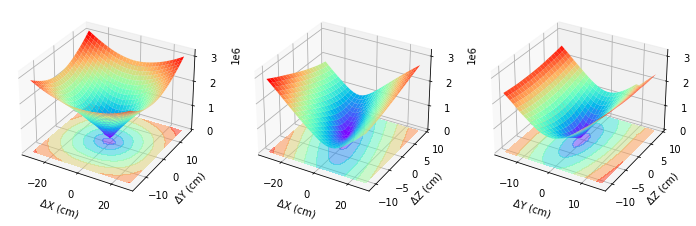

In [7]:
# Make the plots
xyx, xyy = torch.meshgrid(xs - (-100.), ys - 160.1)
xzx, xzz = torch.meshgrid(xs - (-100.), zs - 161.)
yzy, yzz = torch.meshgrid(ys - 160.1, zs - 161.)

fig = plt.figure(figsize=plt.figaspect(1/3))

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.contourf(xyx, xyy, XY, zdir="z", offset=-1, cmap=plt.get_cmap('rainbow'), alpha=0.5)
ax.plot_surface(xyx, xyy, XY, rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'))
ax.set_xlabel('ΔX (cm)')
ax.set_ylabel('ΔY (cm)')
ax.set_zlim3d(0, 3.2e6)

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.contourf(xzx, xzz, XZ, zdir="z", offset=-1, cmap=plt.get_cmap('rainbow'), alpha=0.5)
ax.plot_surface(xzx, xzz, XZ, rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'))
ax.set_xlabel('ΔX (cm)')
ax.set_ylabel('ΔZ (cm)')
ax.set_zlim3d(0, 3.2e6)

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.contourf(yzy, yzz, YZ, zdir="z", offset=-1, cmap=plt.get_cmap('rainbow'), alpha=0.5)
ax.plot_surface(yzy, yzz, YZ, rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'))
ax.set_xlabel('ΔY (cm)')
ax.set_ylabel('ΔZ (cm)')
ax.set_zlim3d(0, 3.2e6)

plt.savefig("../figures/loss_frob.pdf")
plt.show()